## Irfan Kadri
## MMAI 831 AIOS assignment

###Imports

In [2]:
import datetime
import pandas as pd
import numpy as np
import subprocess

from google.colab import data_table
data_table.enable_dataframe_formatter()

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
##from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.model_selection import KFold, StratifiedKFold
##from sklearn.linear_model import LogisticRegression
##from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.style.use('seaborn-v0_8')
#plt.style.use('Solarize_Light2')

### Load, Split Data and EDA

In [3]:
# First, we'll read the provided labeled training data
csv_url = '/content/drive/MyDrive/MMAI_831/AIOS/MMM_Store sales.csv'
df = pd.read_csv(csv_url)
df = df.drop(df.columns[0], axis=1)

In [43]:
seed = 42
sales_train_df, sales_test_df = train_test_split(df, test_size=0.25, random_state=seed)
print(f'Length of sales train = {len(sales_train_df)}')
print(f'Length of sales test = {len(sales_test_df)}')
print(f'Split = {len(sales_test_df)/len(df)*100}%')

Length of sales train = 750
Length of sales test = 250
Split = 25.0%


In [5]:
sales_train_df

,store,billboard,printout,sat,comp,price,sales
82,1656,1074,693,69,931,93,17022.74793
991,1775,1084,853,65,457,97,16735.91408
789,1961,1137,367,74,737,99,21907.37388
894,1904,985,474,65,798,88,17377.57092
398,2003,656,923,71,704,105,14277.05517
...,...,...,...,...,...,...,...
106,1775,1164,601,72,741,92,20119.79590
270,1923,590,832,71,752,107,11513.32661
860,1868,880,766,66,982,96,16802.64631
435,2401,872,1387,68,792,101,18278.74176


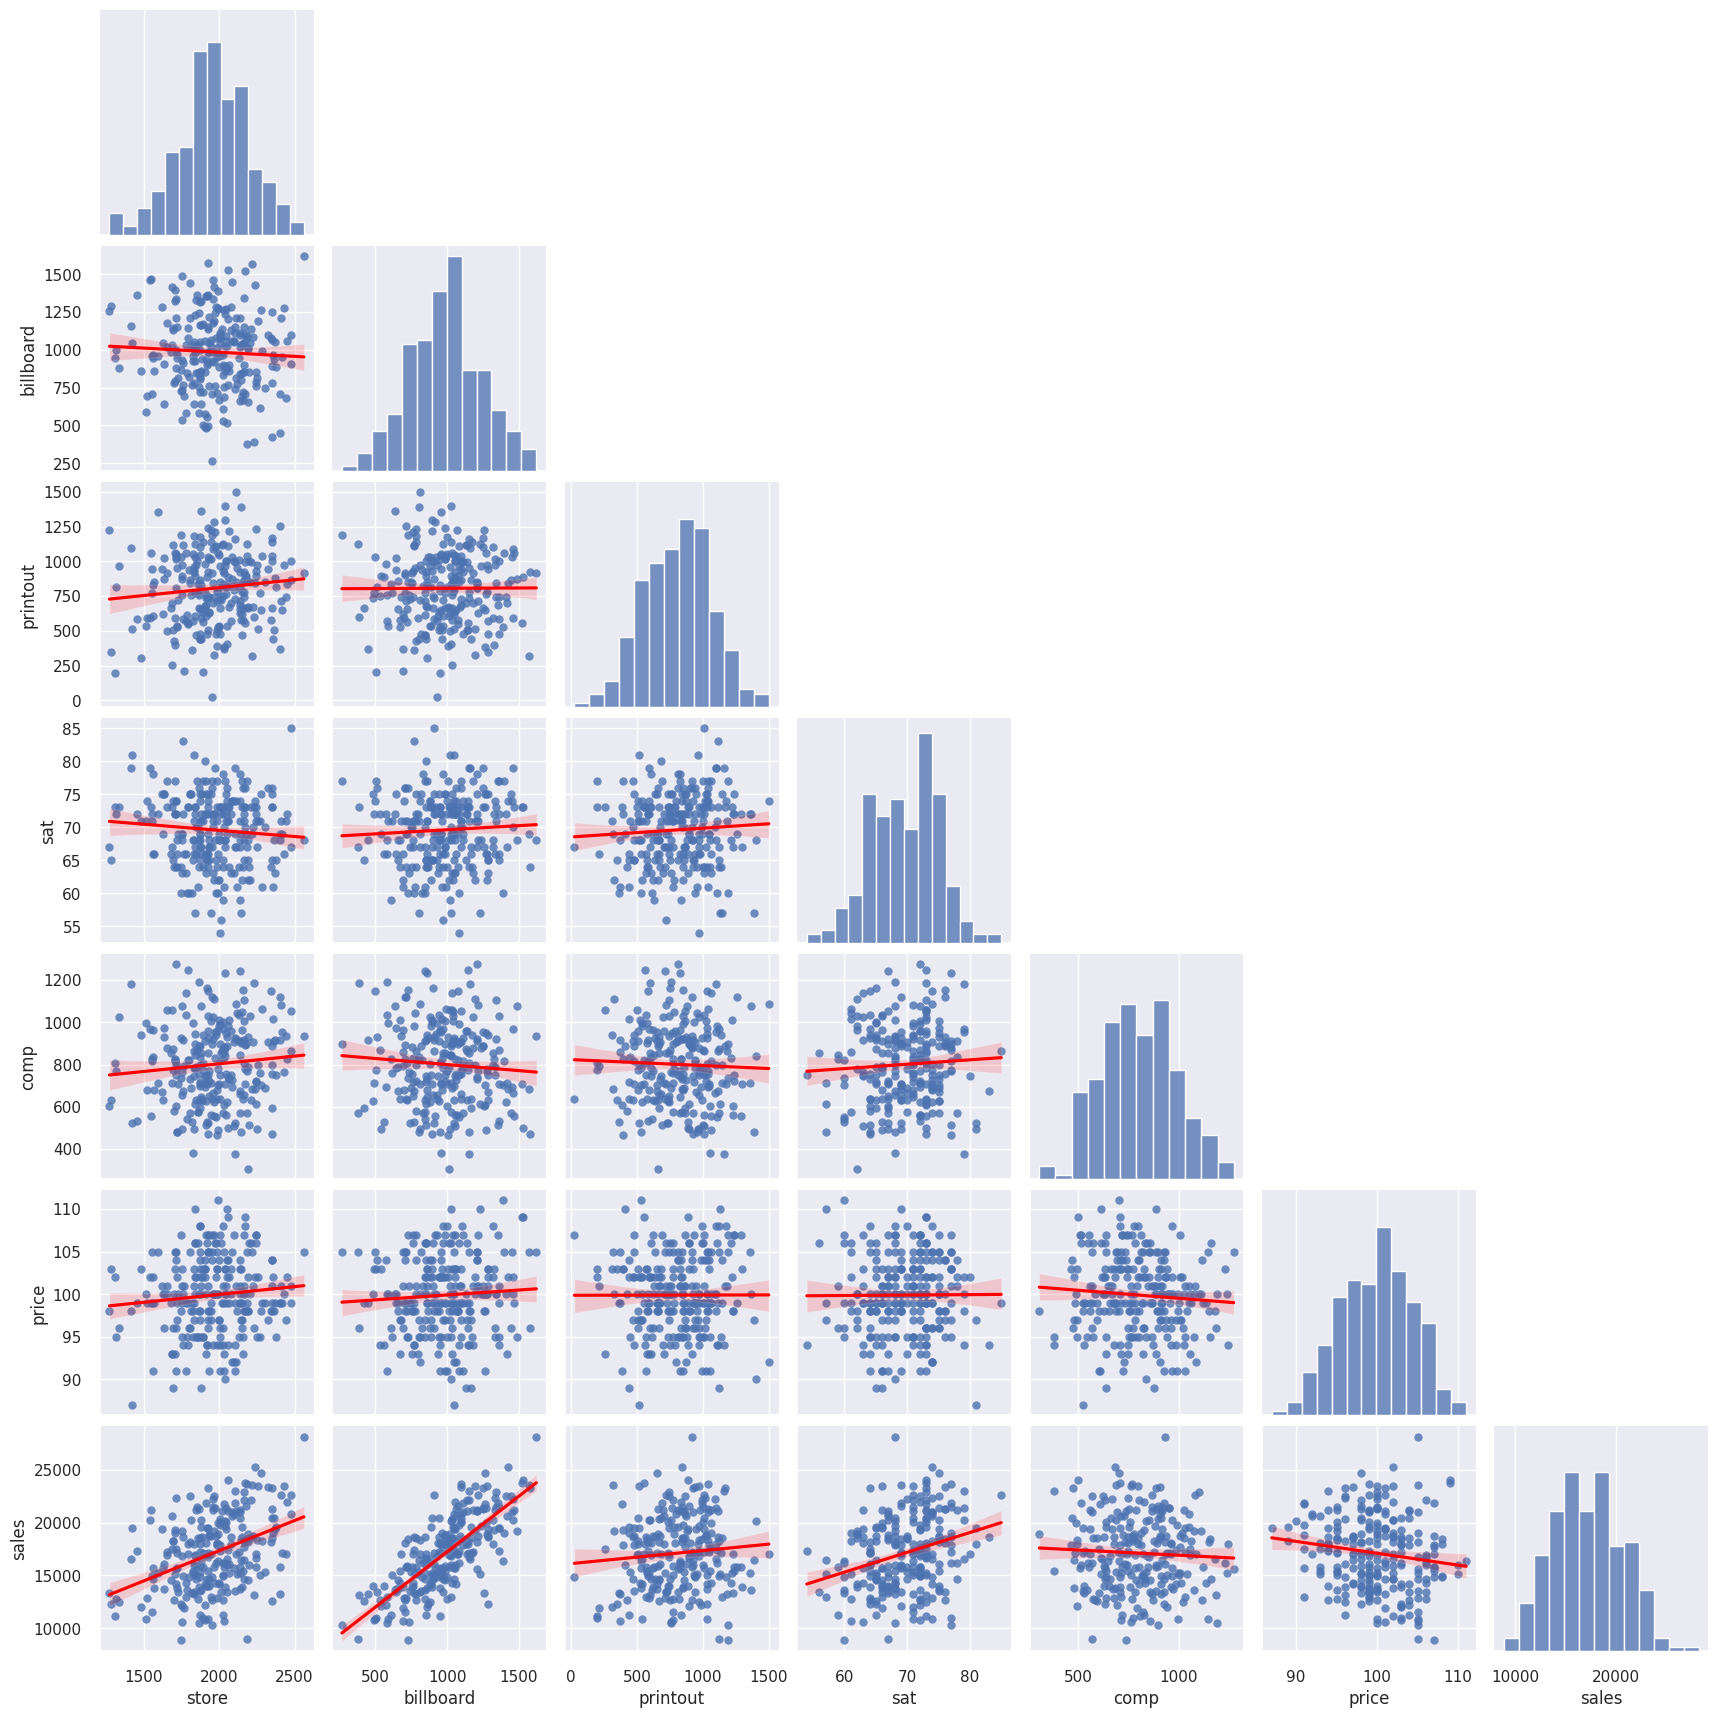

In [76]:
sns.set(rc={'figure.figsize':(2,2)})
sns.pairplot(data=sales_test_df, kind='reg', corner=True, plot_kws={'line_kws':{'color':'red'}})

#### Correlation of the variables

<Axes: >

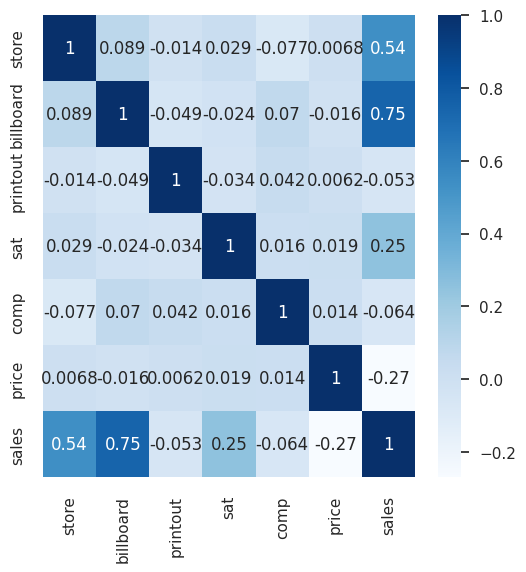

In [77]:
#Lets check if there are any linear correlations between the variables on the data set
correlation_df = sales_train_df.corr()
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_df, annot = True, cmap='Blues')

In [19]:
print(sales_test_df.columns)

Index(['store', 'billboard', 'printout', 'sat', 'comp', 'price', 'sales'], dtype='object')


### Helper functions for training, calculating metrics and for plotting the results

In [78]:
# Lets import some ML algorithm modesl
#Import Linear models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
#Import Tree based Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#Import Clustering 
from sklearn.neighbors import KNeighborsRegressor
#Import XGboost Regressor
from xgboost import XGBRegressor

#Import Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [79]:
#OK lets run some regression - First seperate into X and Y 
X_train = sales_train_df[['store', 'billboard', 'printout', 'sat', 'comp', 'price']]  # independent variables or X
Y_train = sales_train_df['sales']  # dependent variable or Y
X_test = sales_test_df[['store', 'billboard', 'printout', 'sat', 'comp', 'price']]  # independent variables or X
Y_test = sales_test_df['sales']

In [121]:
def fit_and_predict(model, X_train, Y_train, X_test, Y_test, Y_results_df):
    model_name = type(model).__name__
    #Fit on Train data
    model.fit(X_train, Y_train)
    #Do the prediction 
    Y_pred = model.predict(X_test)
    residuals = Y_test - Y_pred
    #coeff = model.coef_
    #y_int = model.intercept_
    
    #Calculate MAE
    mae = mean_absolute_error(Y_pred, Y_test)
    #Calculate r2
    r2 = r2_score(Y_test, Y_pred)
    #Mean Squared Error
    mse = mean_squared_error(Y_test, Y_pred)
    #Calculate RMSE
    rmse = np.sqrt(mse)
    #Calculate MAPD
    mean_actual = np.mean(Y_test)
    absolute_deviation = np.abs(Y_pred - Y_test)
    mapd = np.mean(absolute_deviation / mean_actual) * 100
    # Calculate the log-likelihood
    log_like = -0.5 * np.mean(residuals**2)
    # Get the number of parameters
    n_train_samples = len(Y_train)
    n_test_samples = len(Y_test)
    n_features = X_test.shape[1]
    n_params = n_features + 1  # Add 1 for the intercept term
    # Calculate AIC
    aic = -2 * log_like + 2 * n_params
    # Calculate BIC
    bic = -2 * log_like + n_params * np.log(n_test_samples)

    #Wrap all this information into a Data Frame for further plotting or interprettion downstream
    model_results_df = pd.DataFrame({'Model': model_name, 'Actual_Sales': Y_test, 'Predicted_Sales': Y_pred, 
                                     'Residuals': residuals, 'mae[$]': mae, 'r2': r2, 'rmse[$]': rmse, 'MAPD':mapd, 'AIC':aic, 'BIC':bic})
    Y_results_df = pd.concat([Y_results_df, model_results_df], ignore_index=True)
    return Y_results_df

In [128]:
def plot_predict_and_residuals(model, Y_results_df):
    model_name = type(model).__name__
    model_results_df = Y_results_df[Y_results_df['Model'] == model_name]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 14))
    # Plot the Actual Test data
    sns.scatterplot(data=model_results_df, x='Actual_Sales', y='Predicted_Sales', label= 'Actual vs. Predicted', ax=ax1)
    # Plot the regression line
    sns.lineplot(data=model_results_df, x=Y_test, y=Y_test, color='red', linewidth=2,linestyle='--', label='Ideal',ax=ax1)
    ax1.set_xlabel('Actual Sales')
    ax1.set_ylabel('Predicted Sales')
    ax1.set_title(f'{model_name}: Actual vs Predicted Sales')
    mae = model_results_df['mae[$]'].mean()
    r2 = model_results_df['r2'].mean()
    rmse = model_results_df['rmse[$]'].mean()
    mapd = model_results_df['MAPD'].mean()
    aic = model_results_df['AIC'].mean()
    bic = model_results_df['BIC'].mean()
    ax1.text(0.95, 0.25, f'MAE[$]: {mae:.2f}\n R2: {r2:.2f}\n RMSE[$]: {rmse}\n MAPD: {mapd:.2f}\n AIC: {aic:,.2f}\n BIC: {bic:,.2f}', transform=ax1.transAxes, ha='right', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    ax1.legend()

    #Plot the residuals
    sns.scatterplot(data=model_results_df, x='Predicted_Sales', y='Residuals',ax=ax2)
    ax2.set_ylim(-4000, 4000)
    ax2.axhline(y=0, color='red', linestyle='--')
    ax2.set_xlabel('Predicted Sales')
    ax2.set_ylabel('Residuals')
    ax2.set_title(f'{model_name}: Residual Plot')

    plt.tight_layout()
    plt.show()

### Run Simple Linear Regression

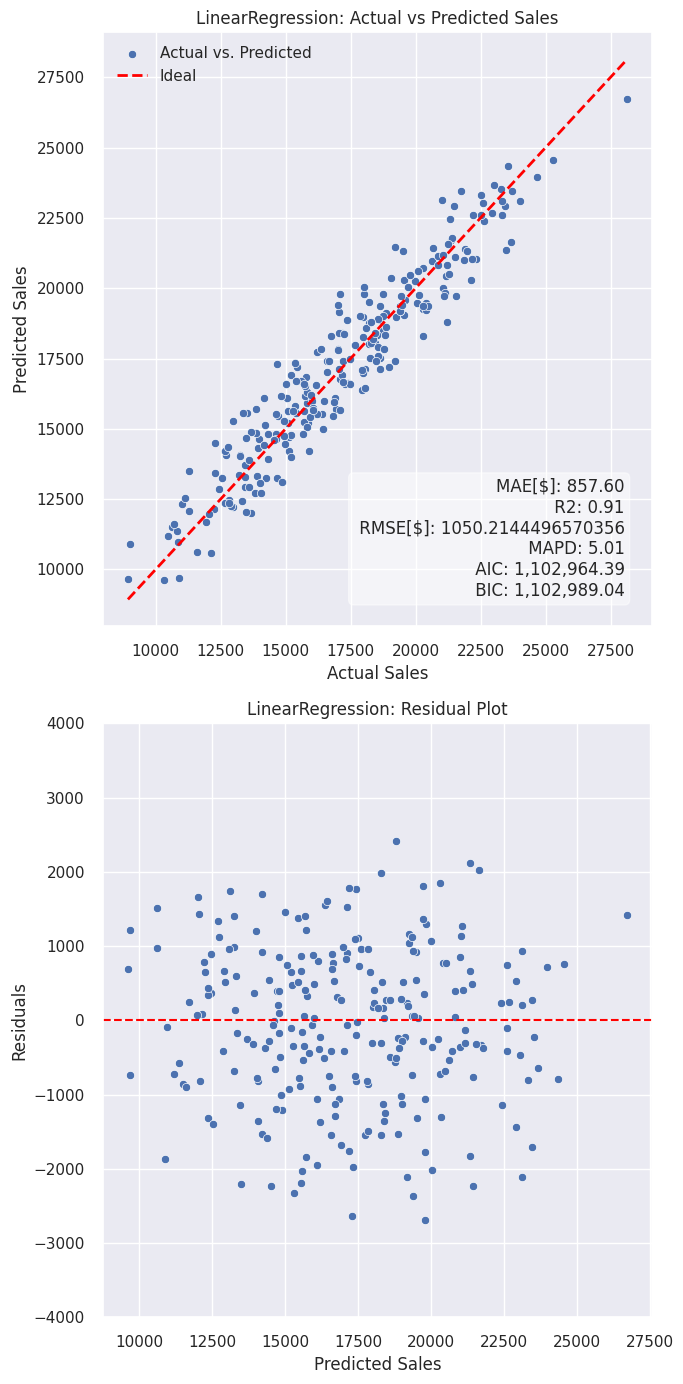

In [129]:
# Lets run a simple linear regression
Y_results_df = pd.DataFrame()
#Linear Regression Model
model = LinearRegression()
Y_results_df = fit_and_predict(model, X_train, Y_train, X_test, Y_test, Y_results_df)
plot_predict_and_residuals(model, Y_results_df)


In [ ]:
Y_results_df

In [84]:
# Ignore this section I am still working on it
#Lets calculate metrics
model_results_df = pd.DataFrame()
model_name ='LinearRegression'
model_results_df = Y_results_df[Y_results_df['Model'] == model_name]
select_columns = ['Model', 'Actual_Sales', 'Predicted_Sales', 'Residuals']
model_results_df = model_results_df[select_columns]
model_results_df = model_results_df.merge(sales_test_df, left_on='Actual_Sales', right_on='sales')
model_results_df

selected_columns = ['store', 'billboard','printout', 'sat', 'comp', 'price']
std_error = model_results_df[selected_columns].sem()
print(std_error)

store        15.313836
billboard    15.954276
printout     16.185474
sat           0.336674
comp         11.931044
price         0.287141
dtype: float64


In [ ]:
model_results_df

#### Check for Heteroscedasticity

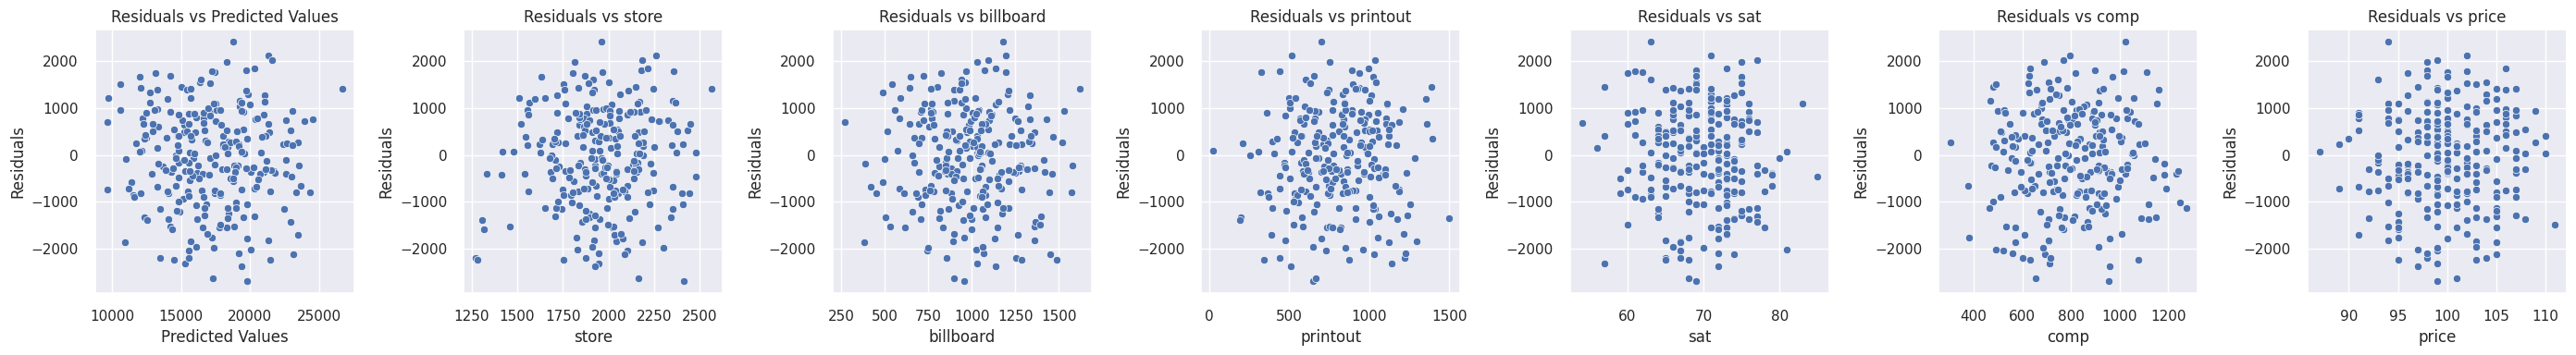

In [130]:
#Lets check for heteroscedasticity
# Plot the residuals against the predicted values
Y_pred = model_results_df['Predicted_Sales']
residuals = model_results_df['Residuals']
selected_columns = ['store', 'billboard','printout', 'sat', 'comp', 'price']
X = model_results_df[selected_columns].values

#plt.figure(figsize=(6, 6))
# Set the figure size
fig, axs = plt.subplots(1, len(selected_columns) + 1, figsize=(28, 4))

# Plot the residuals against the predicted values
sns.scatterplot(x=Y_pred, y=residuals, ax=axs[0])
axs[0].set_xlabel('Predicted Values')
axs[0].set_ylabel('Residuals')
axs[0].set_title('Residuals vs Predicted Values')

# Plot the residuals against the independent variables
for i, column in enumerate(selected_columns):
    sns.scatterplot(x=model_results_df[column], y=residuals, ax=axs[i+1])
    axs[i+1].set_xlabel(column)
    axs[i+1].set_ylabel('Residuals')
    axs[i+1].set_title(f'Residuals vs {column}')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Run Multiple ML models to select the best one that fits the data

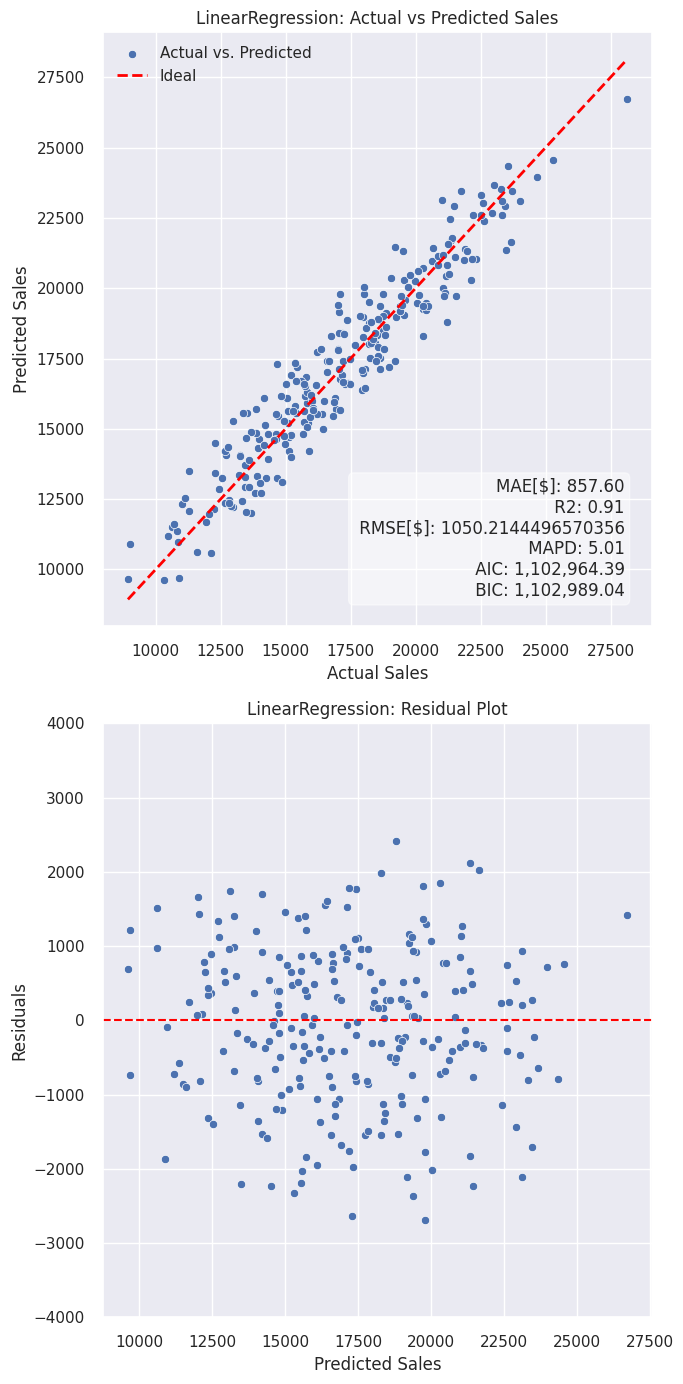

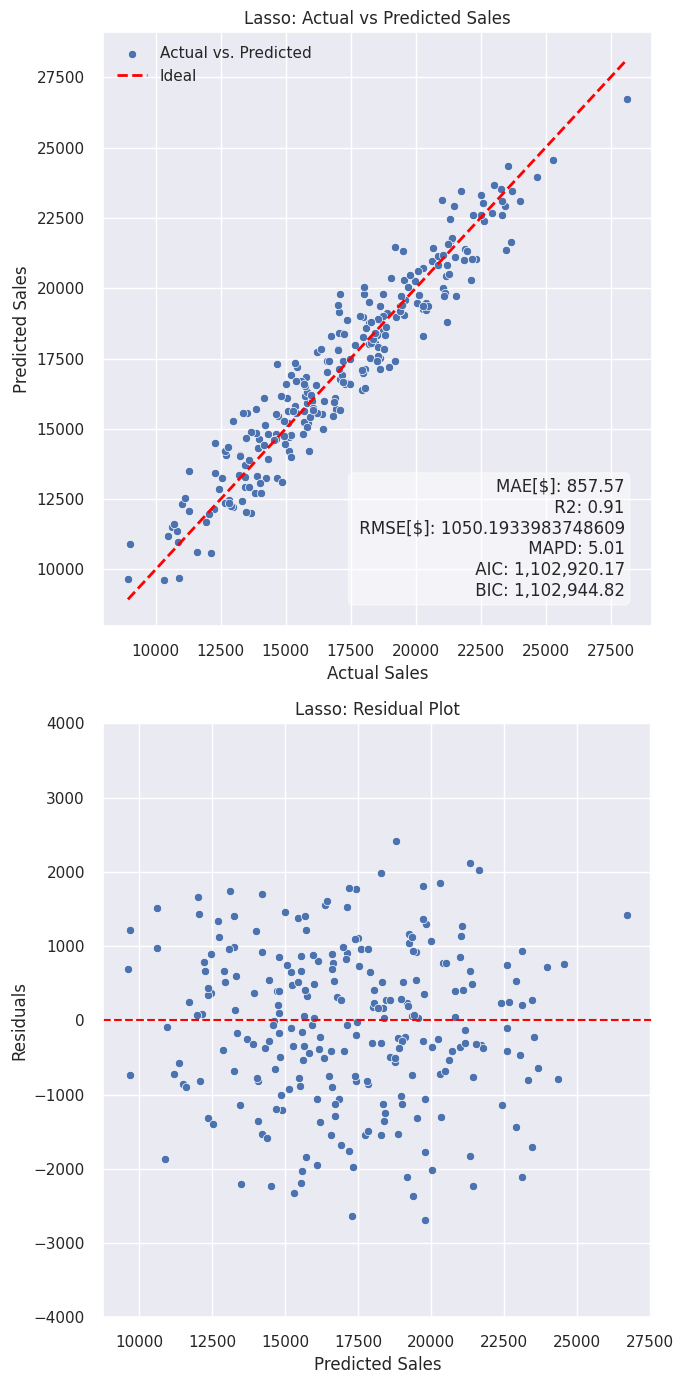

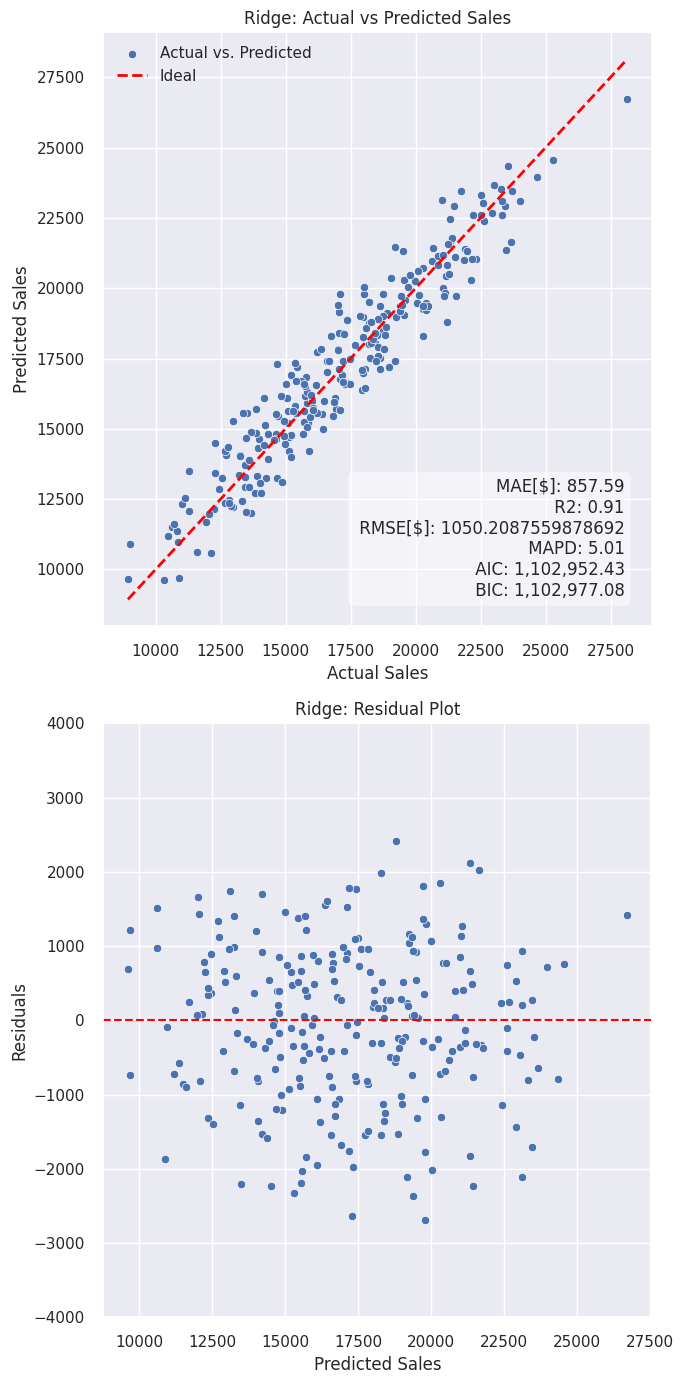

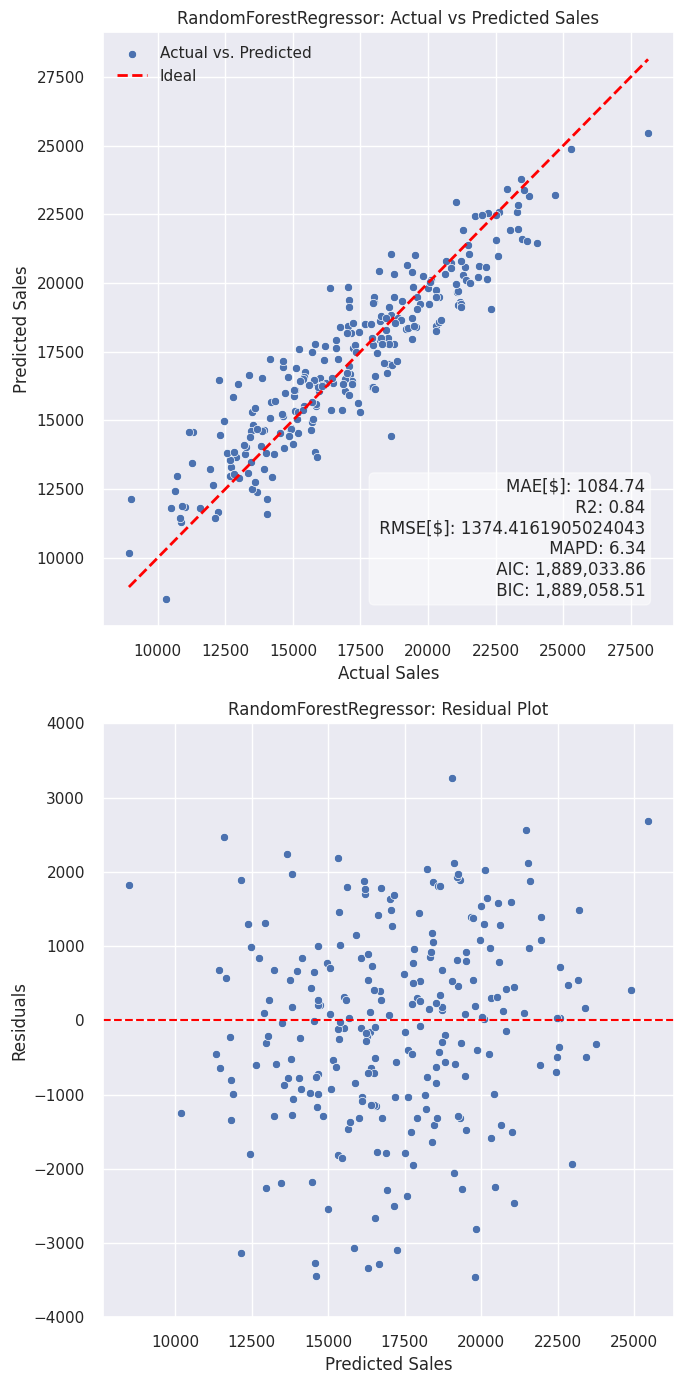

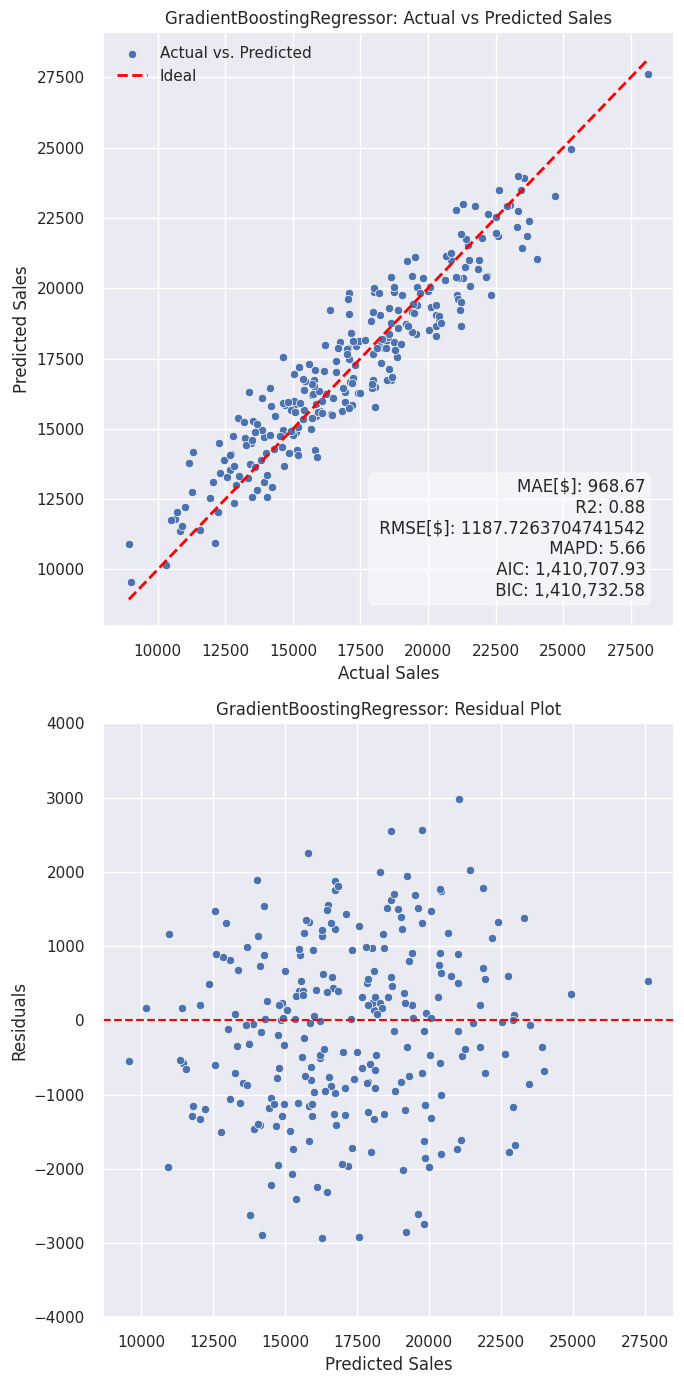

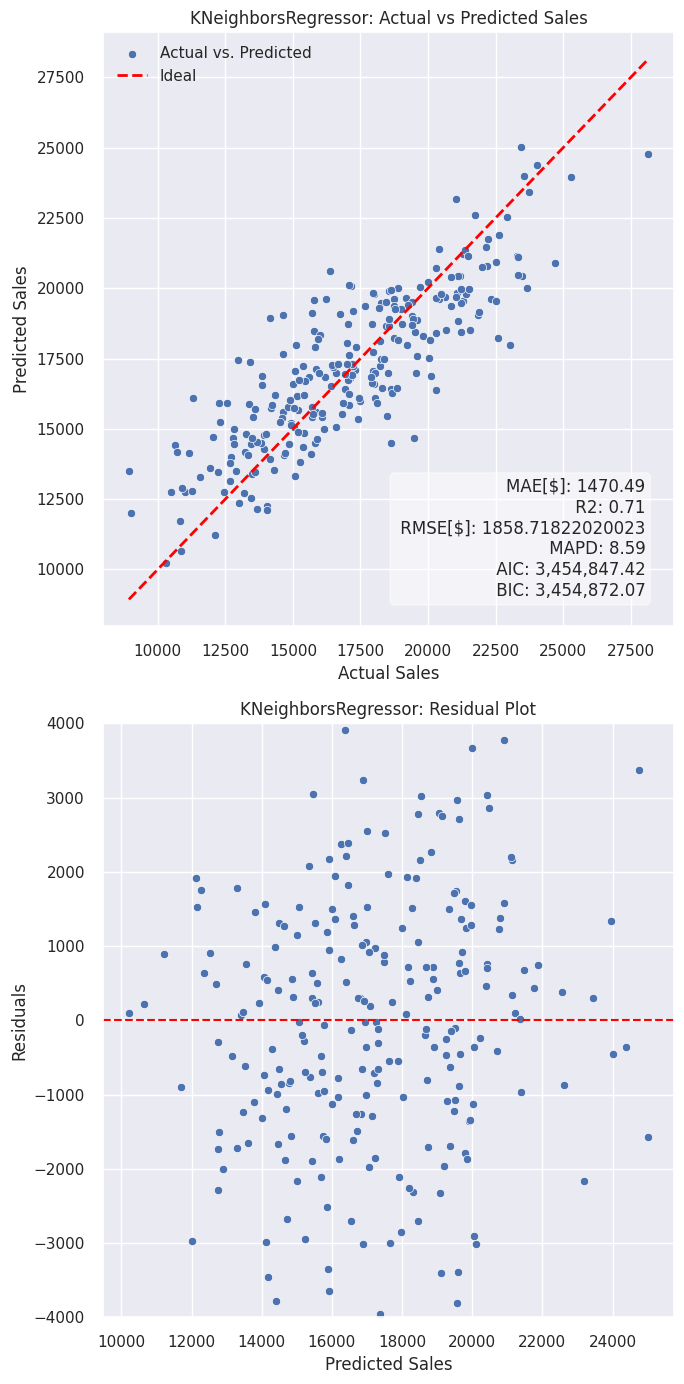

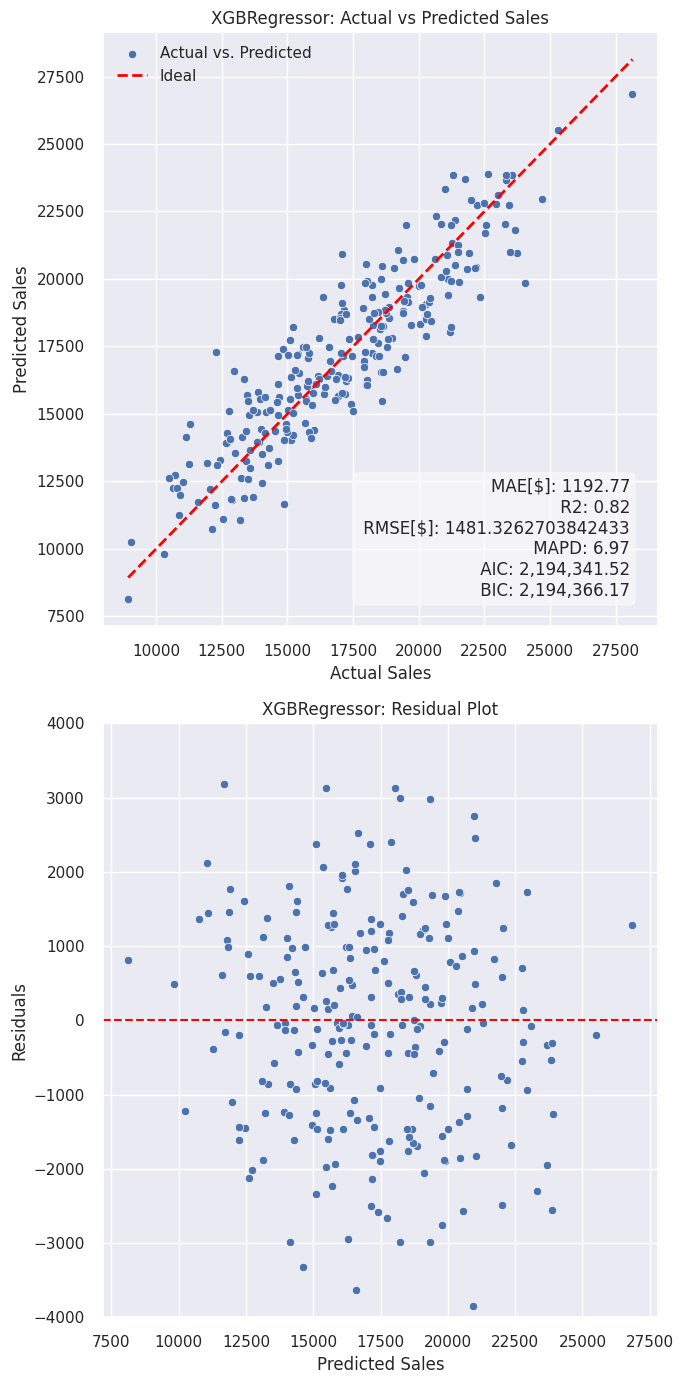

In [131]:
#Lets run many different ML model types to see which one gives us the best performance
Y_results_df = pd.DataFrame()
#Linear Regression Model
model = LinearRegression()
Y_results_df = fit_and_predict(model, X_train, Y_train, X_test, Y_test, Y_results_df)
plot_predict_and_residuals(model, Y_results_df)
#Lasso Model
model = Lasso()
Y_results_df =fit_and_predict(model, X_train, Y_train, X_test, Y_test, Y_results_df)
plot_predict_and_residuals(model,Y_results_df)
#Ridge Regression Model
model = Ridge()
Y_results_df = fit_and_predict(model, X_train, Y_train, X_test, Y_test, Y_results_df)
plot_predict_and_residuals(model,Y_results_df)
#Random Forest Regression model
model = RandomForestRegressor()
Y_results_df = fit_and_predict(model, X_train, Y_train, X_test, Y_test, Y_results_df)
plot_predict_and_residuals(model,Y_results_df)
#Gradient Boosting Regressor model
model= GradientBoostingRegressor()
Y_results_df = fit_and_predict(model, X_train, Y_train, X_test, Y_test, Y_results_df)
plot_predict_and_residuals(model,Y_results_df)
#K-Neighbours Regressor model
model = KNeighborsRegressor()
Y_results_df = fit_and_predict(model, X_train, Y_train, X_test, Y_test, Y_results_df)
plot_predict_and_residuals(model,Y_results_df)
#XGBoost
model = XGBRegressor()
Y_results_df = fit_and_predict(model, X_train, Y_train, X_test, Y_test, Y_results_df)
plot_predict_and_residuals(model,Y_results_df)

#### Summary of ML model performance

In [137]:
metrics_df = Y_results_df.groupby('Model').agg({'mae[$]': 'mean', 'r2': 'mean', 'rmse[$]': 'mean', 'MAPD': 'mean', 'AIC': 'mean', 'BIC': 'mean'})
metrics_df

,mae[$],r2,rmse[$],MAPD,AIC,BIC
Model,,,,,,
GradientBoostingRegressor,968.668004,0.883452,1187.726370,5.659920,1.410708e+06,1.410733e+06
KNeighborsRegressor,1470.488471,0.714569,1858.718220,8.592054,3.454847e+06,3.454872e+06
Lasso,857.567859,0.908880,1050.193398,5.010763,1.102920e+06,1.102945e+06
LinearRegression,857.604415,0.908877,1050.214450,5.010977,1.102964e+06,1.102989e+06
RandomForestRegressor,1084.739032,0.843933,1374.416191,6.338123,1.889034e+06,1.889059e+06
Ridge,857.594474,0.908878,1050.208756,5.010919,1.102952e+06,1.102977e+06
XGBRegressor,1192.770476,0.818709,1481.326270,6.969350,2.194342e+06,2.194366e+06


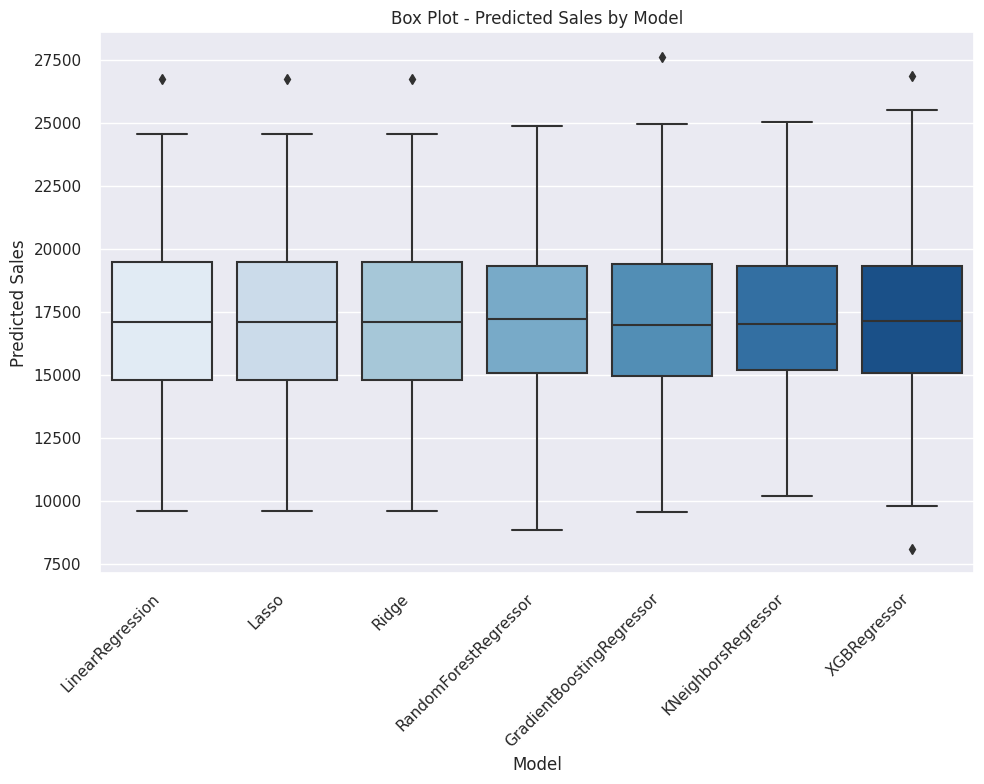

In [33]:
## Ignore this for now still working on it
#Lets plot the distribution of the Sales figures
fig, ax = plt.subplots(figsize=(10, 8))
#sns.boxplot(data=Y_results_df, x='Model', y='Actual_Sales', ax=ax)
sns.boxplot(data=Y_results_df, x='Model', y='Predicted_Sales', ax=ax, palette='Blues')
ax.set_xlabel('Model')
ax.set_ylabel('Predicted Sales')
ax.set_title('Box Plot - Predicted Sales by Model')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()